This notebook describes how to create plots for the netCDF file(s) obtained after executing `DIVAnd`.     
We will use the [NetCDF](https://github.com/JuliaGeo/NetCDF.jl) module to read the result files and [PyPlot](https://github.com/JuliaPy/PyPlot.jl).

In [1]:
using NetCDF  
using PyPlot

Adapt the file directory and name.      
We can use for example the salinity analysis produced by [example-analysis.ipynb](../example-analysis.ipynb).

In [2]:
datadir = "./"
datafile = joinpath(datadir, "Water_body_Salinity.4Danl.nc")
if isfile(datafile)
    info("File exist") 
else
    error("File does not exist")
end

INFO: File exist


Open the file for reading

In [27]:
nc = NetCDF.open(datafile);

Inspect the dimensions (dictionaries):

In [6]:
nc.dim

Dict{String,NetCDF.NcDim} with 5 entries:
  "lat"   => NetCDF.NcDim(65536, 1, 1, "lat", 0x0000000000000024, Any[], Dict{A…
  "depth" => NetCDF.NcDim(65536, 2, 2, "depth", 0x0000000000000003, Any[], Dict…
  "time"  => NetCDF.NcDim(65536, 3, 3, "time", 0x0000000000000008, Any[], Dict{…
  "nv"    => NetCDF.NcDim(65536, 4, -1, "nv", 0x0000000000000002, Any[], Dict{A…
  "lon"   => NetCDF.NcDim(65536, 0, 0, "lon", 0x000000000000004c, Any[], Dict{A…

and the variables:

In [7]:
nc.vars

Dict{String,NetCDF.NcVar} with 8 entries:
  "lat"             => [40.0, 40.2, 40.4, 40.6, 40.8, 41.0, 41.2, 41.4, 41.6, 4…
  "depth"           => [0.0, 20.0, 50.0]
  "time"            => [34014.0, 34103.0, 34195.0, 34287.0, 34379.0, 34468.0, 3…
  "Salinity_L2"     => Float32[9.96921f36 9.96921f36 … 9.96921f36 9.96921f36; 9…
  "Salinity"        => Float32[9.96921f36 9.96921f36 … 9.96921f36 9.96921f36; 9…
  "Salinity_relerr" => Float32[9.96921f36 9.96921f36 … 9.96921f36 9.96921f36; 9…
  "lon"             => [27.0, 27.2, 27.4, 27.6, 27.8, 28.0, 28.2, 28.4, 28.6, 2…
  "Salinity_L1"     => Float32[9.96921f36 9.96921f36 … 9.96921f36 9.96921f36; 9…

Note that the dimensions (lon, lat, time and depth) are also variables.     
Let's read the dimensions and the salinity field.

In [8]:
lon = ncread(datafile, "lon");
lat = ncread(datafile, "lat");
depth = ncread(datafile, "depth");
time = ncread(datafile, "time");
salinity = ncread(datafile, "Salinity");

Let's also read the time units:

In [10]:
timeunits = nc.vars["time"].atts["units"];
@show timeunits

timeunits = "days since 1900-01-01 00:00:00"


"days since 1900-01-01 00:00:00"

# Create plots
## Simple pseudo color plot
Let's assume we want to plot a given time period at a given depth:

In [11]:
depthplot = 20.;
timeplot = 34195.0;

First we extract the indices of the the time and depth arrays.

In [12]:
timeindex = find(time .== timeplot);
depthindex = find(depth .== depthplot);

Then we extract the 2-D salinity field. If we are not sure about the dimension order, we can check the matrix size.      
Also note the use of [`squeeze`](https://docs.julialang.org/en/stable/stdlib/arrays/#Base.squeeze) to remove the unnecessary dimensions.

In [13]:
@show size(salinity);
salinityplot = salinity[:, :, depthindex, timeindex];
@show size(salinityplot);
salinityplot = squeeze(salinityplot, (3, 4));
@show size(salinityplot);

size(salinity) = (76, 36, 3, 8)
size(salinityplot) = (76, 36, 1, 1)
size(salinityplot) = (76, 36)


Now we can easily create a simple plot.

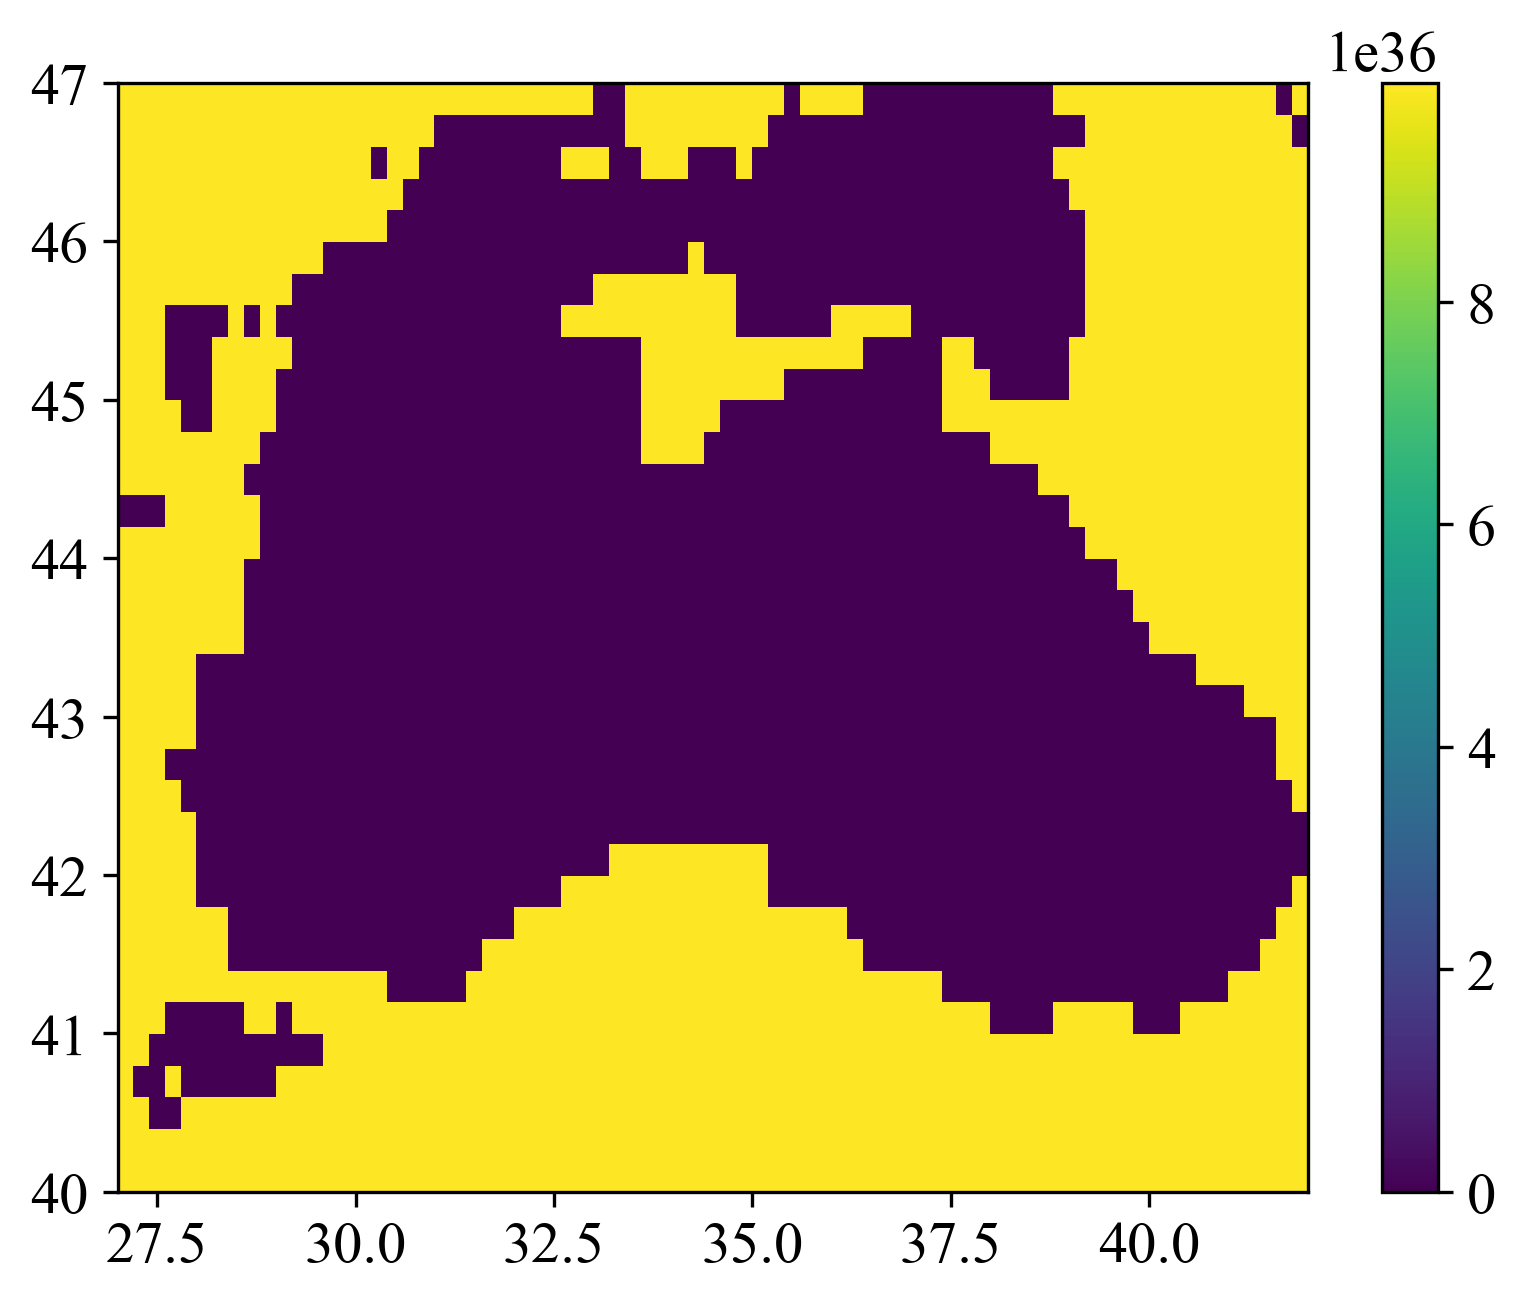

In [14]:
pcolormesh(lon, lat, transpose(salinityplot))
colorbar()
show()

### Masking land
Obviously the land-sea mask was not taken into account:

In [15]:
maxval = maximum(salinityplot)

9.96921f36

A solution could be to specify the minimal and maximal values using `vmin` and `vmax` parameters in the `pcolormesh` function:

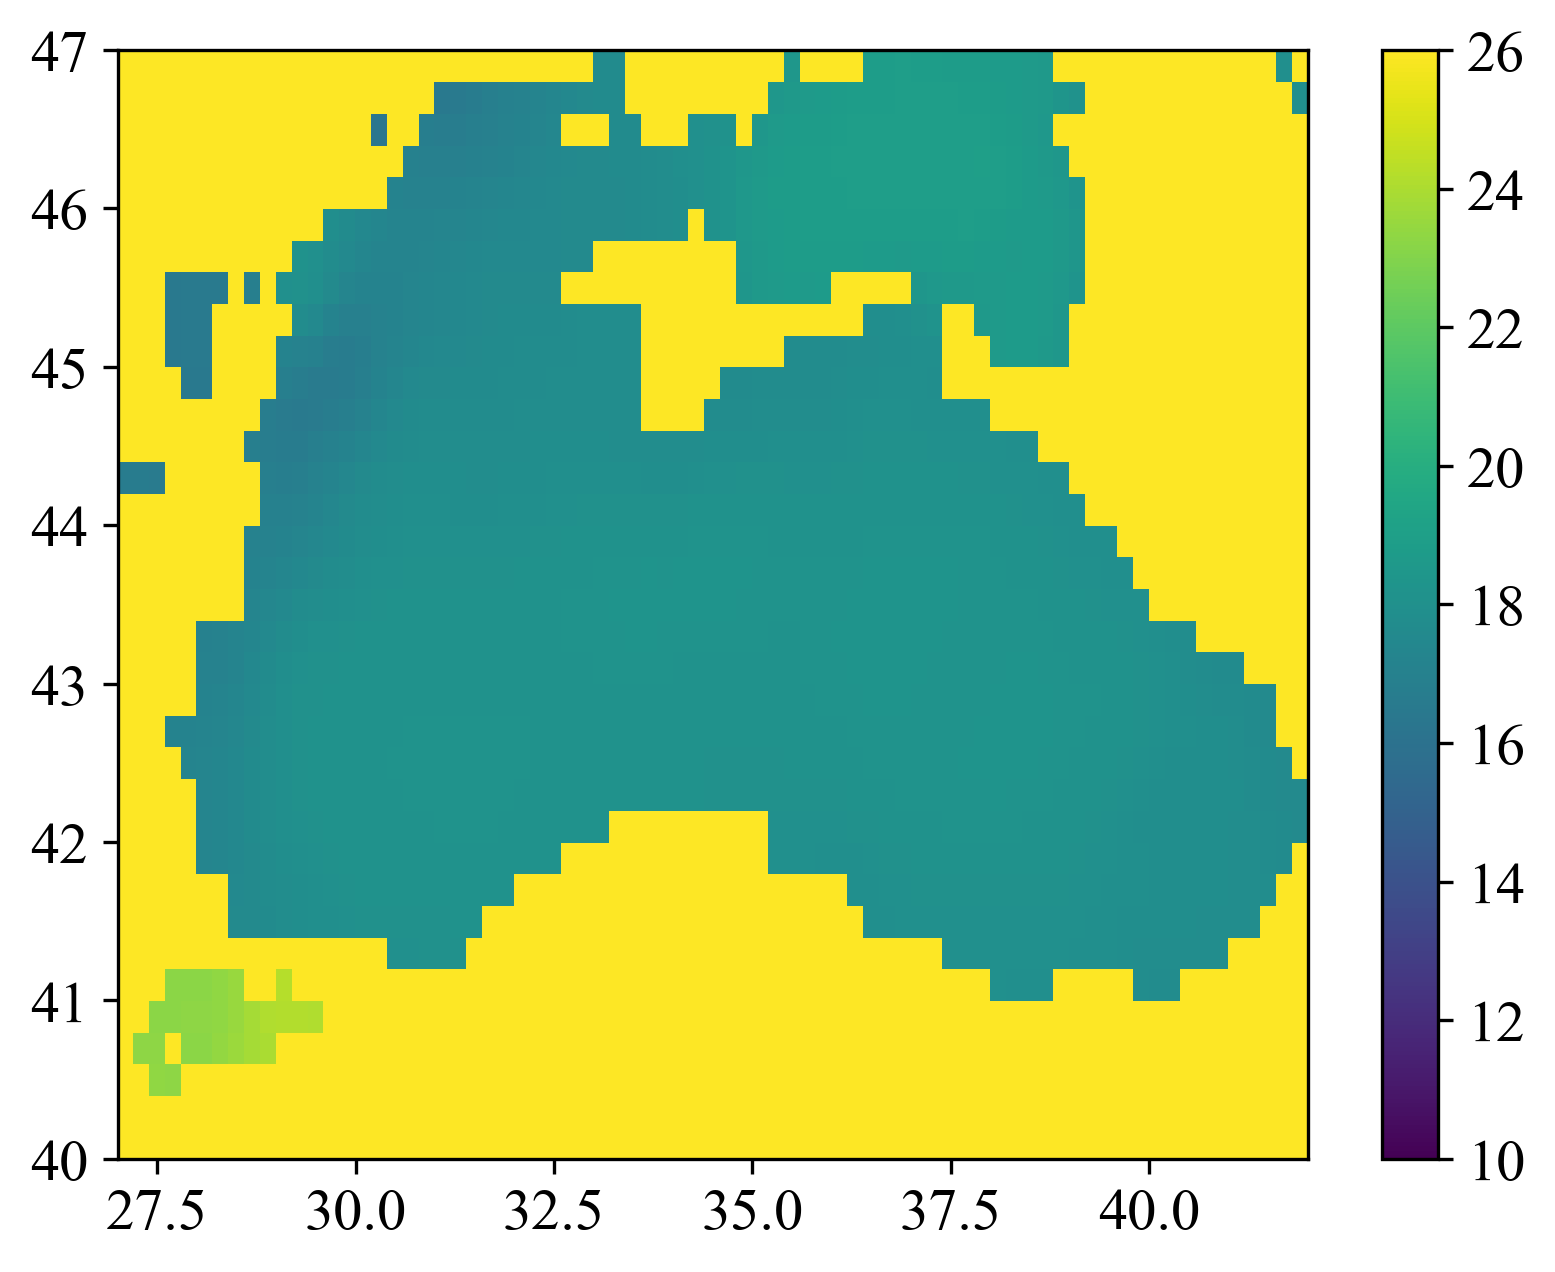

In [16]:
pcolormesh(lon, lat, transpose(salinityplot), vmin=10, vmax=26)
colorbar()
show()

Or we can set the land values (which are equal to the `maxval` defined before) to NaN:

In [17]:
salinityplot[salinityplot .== maxval] = NaN;

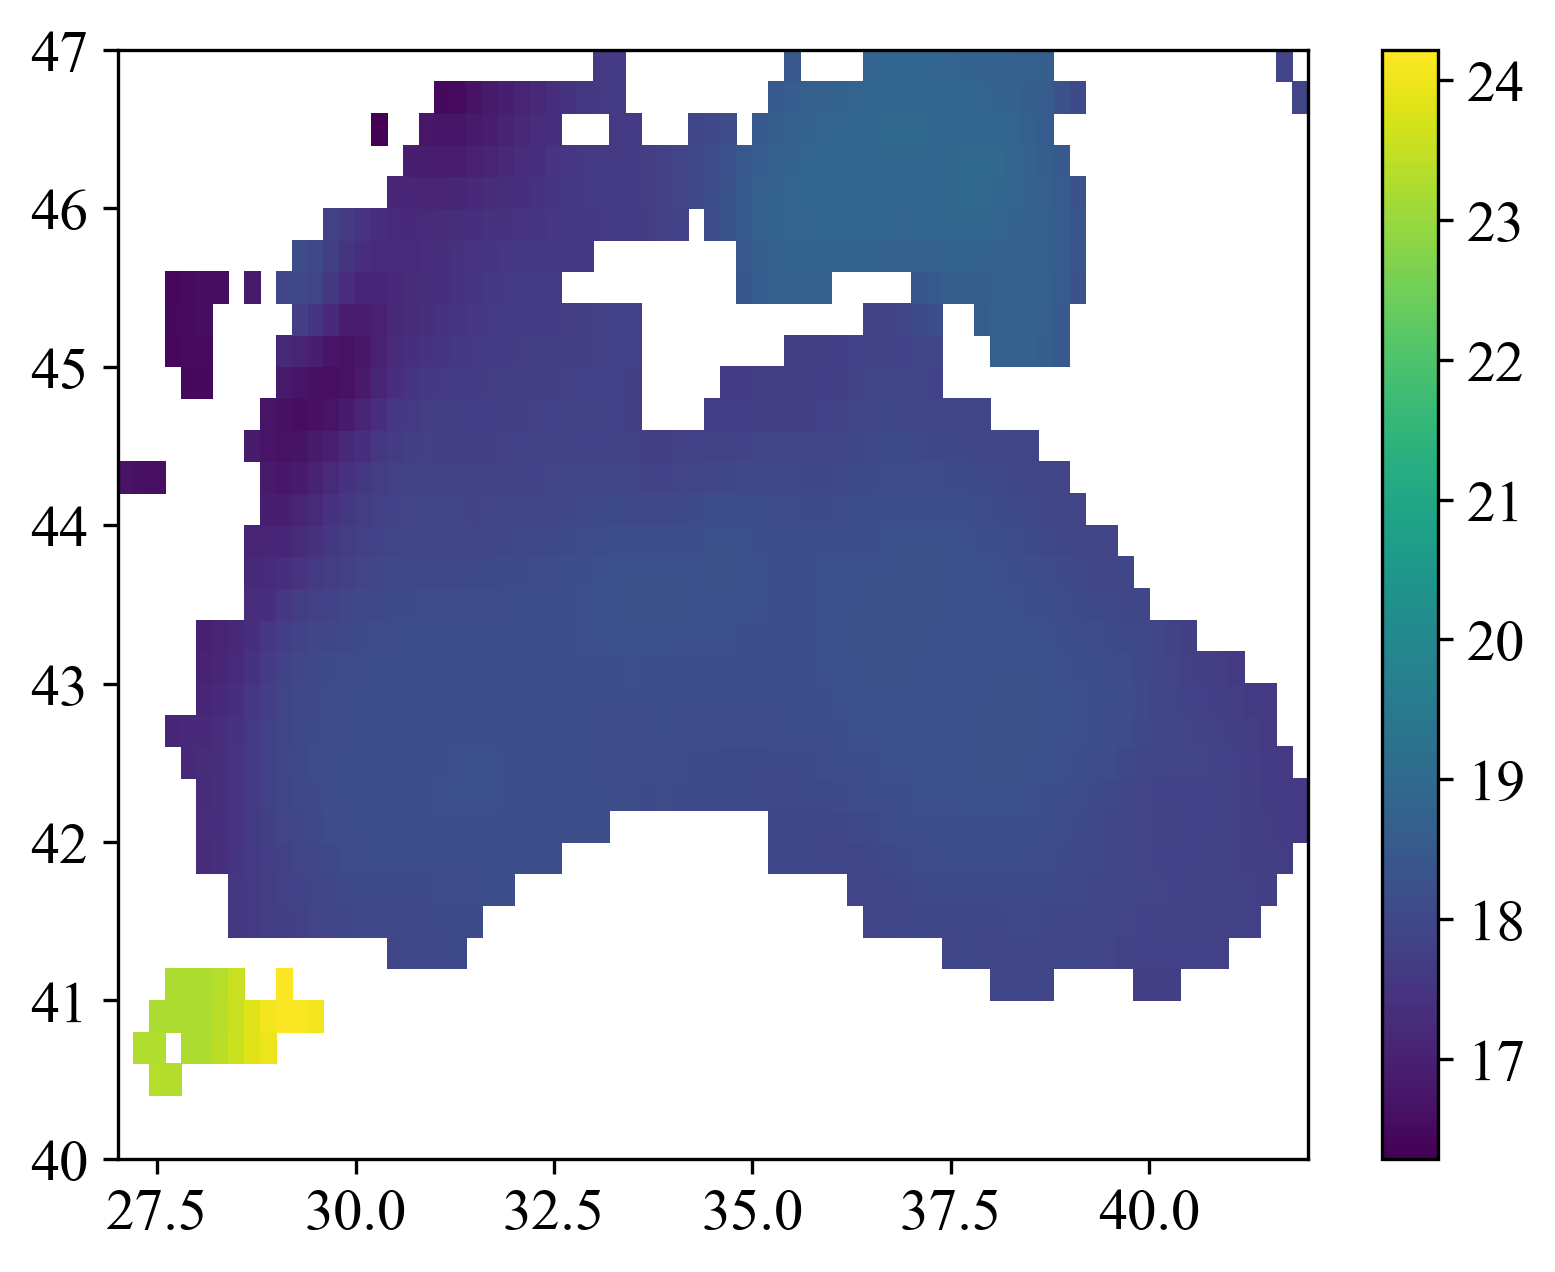

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9b6f5e1a90>

In [21]:
pcolormesh(lon, lat, transpose(salinityplot));
colorbar()

## Contour plots
We explicitely specify the levels to be represented (from 15 to 25).    

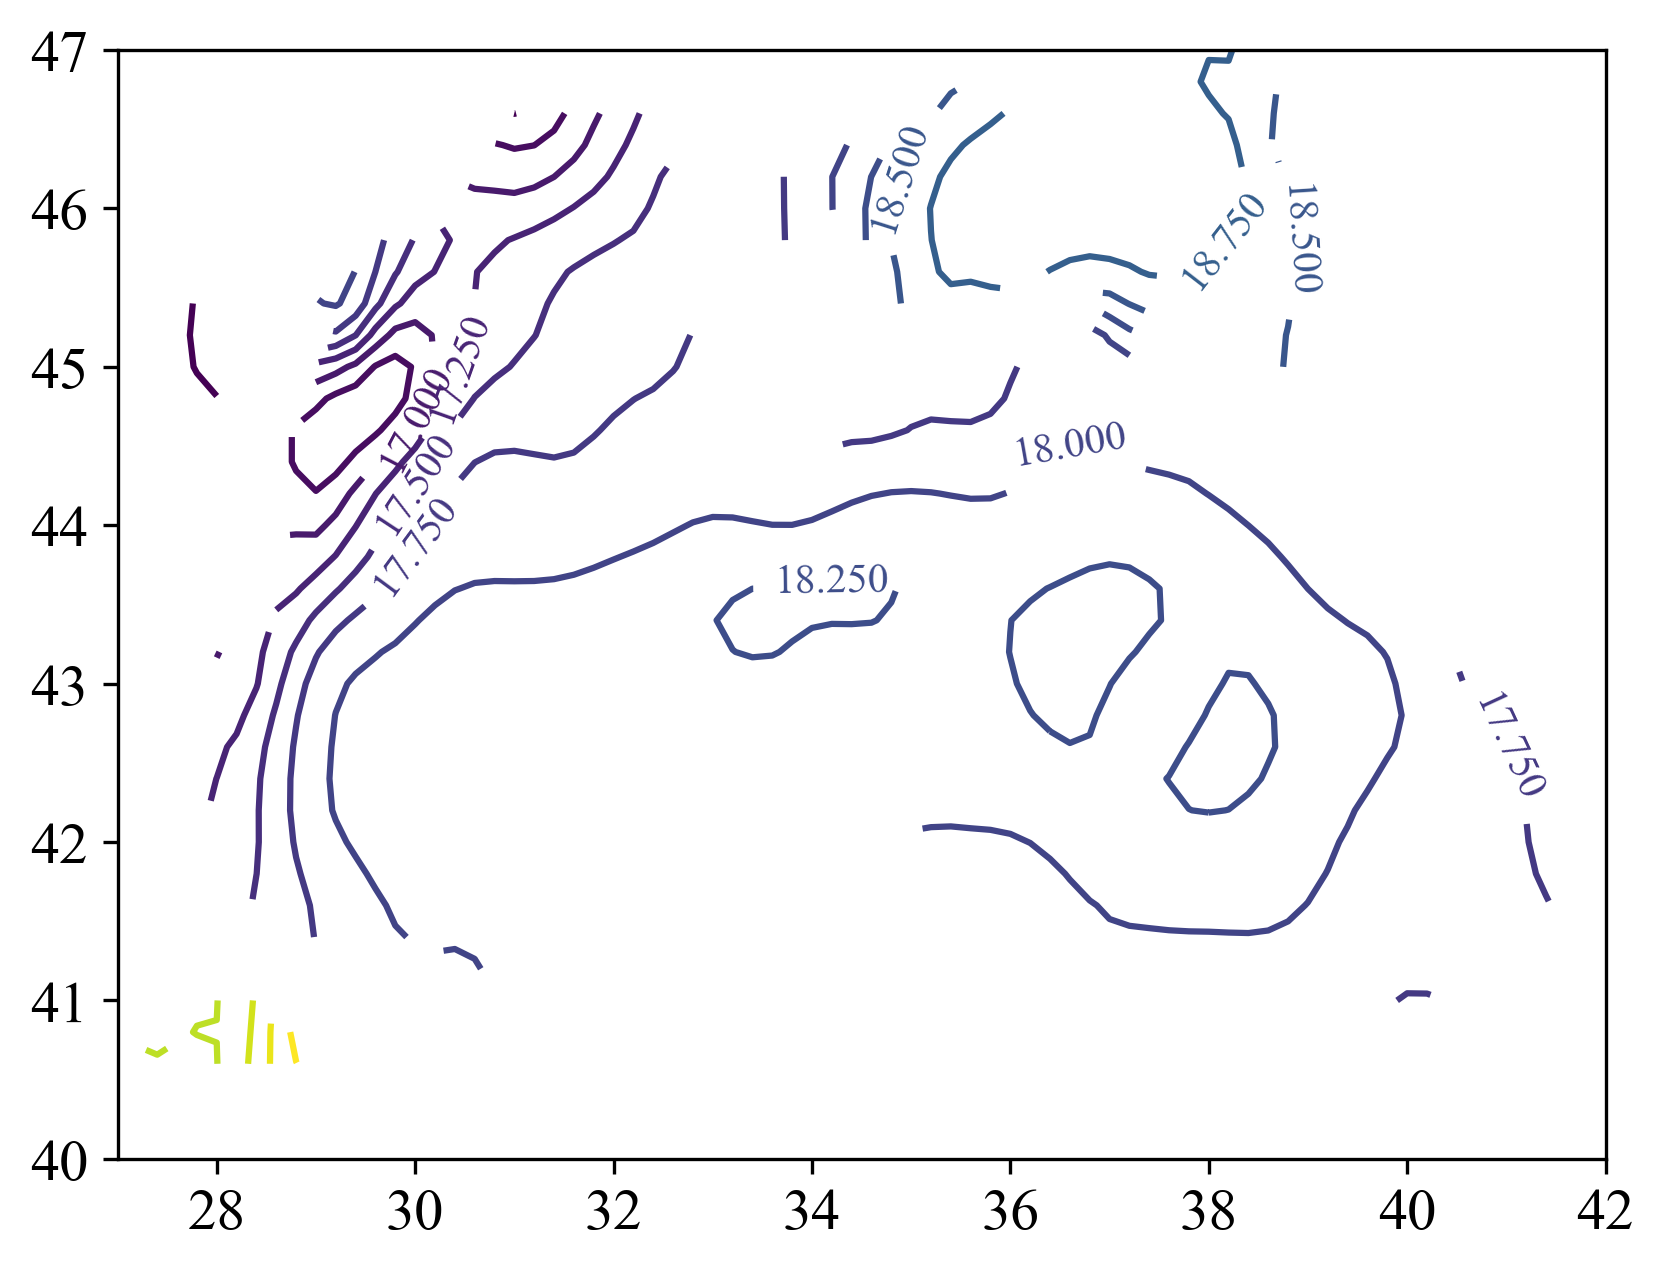

10-element Array{PyCall.PyObject,1}:
 PyObject Text(30,44.6795,'17.000')  
 PyObject Text(30.4365,45,'17.250')  
 PyObject Text(30,44.2674,'17.500')  
 PyObject Text(41.0076,42.6,'17.750')
 PyObject Text(30,43.8769,'17.750')  
 PyObject Text(36.6,44.5023,'18.000')
 PyObject Text(34.2,43.6443,'18.250')
 PyObject Text(38.8903,45.8,'18.500')
 PyObject Text(34.8741,46.2,'18.500')
 PyObject Text(38.1562,45.8,'18.750')

In [19]:
conts = contour(lon, lat, transpose(salinityplot), levels=collect(15:.25:25))
clabel(conts, inline=1, fontsize=10);

We will show in another notebook how to add the coastlines and other map features.

## Filled contour plots
The aspect is somehow different from the pcolor.

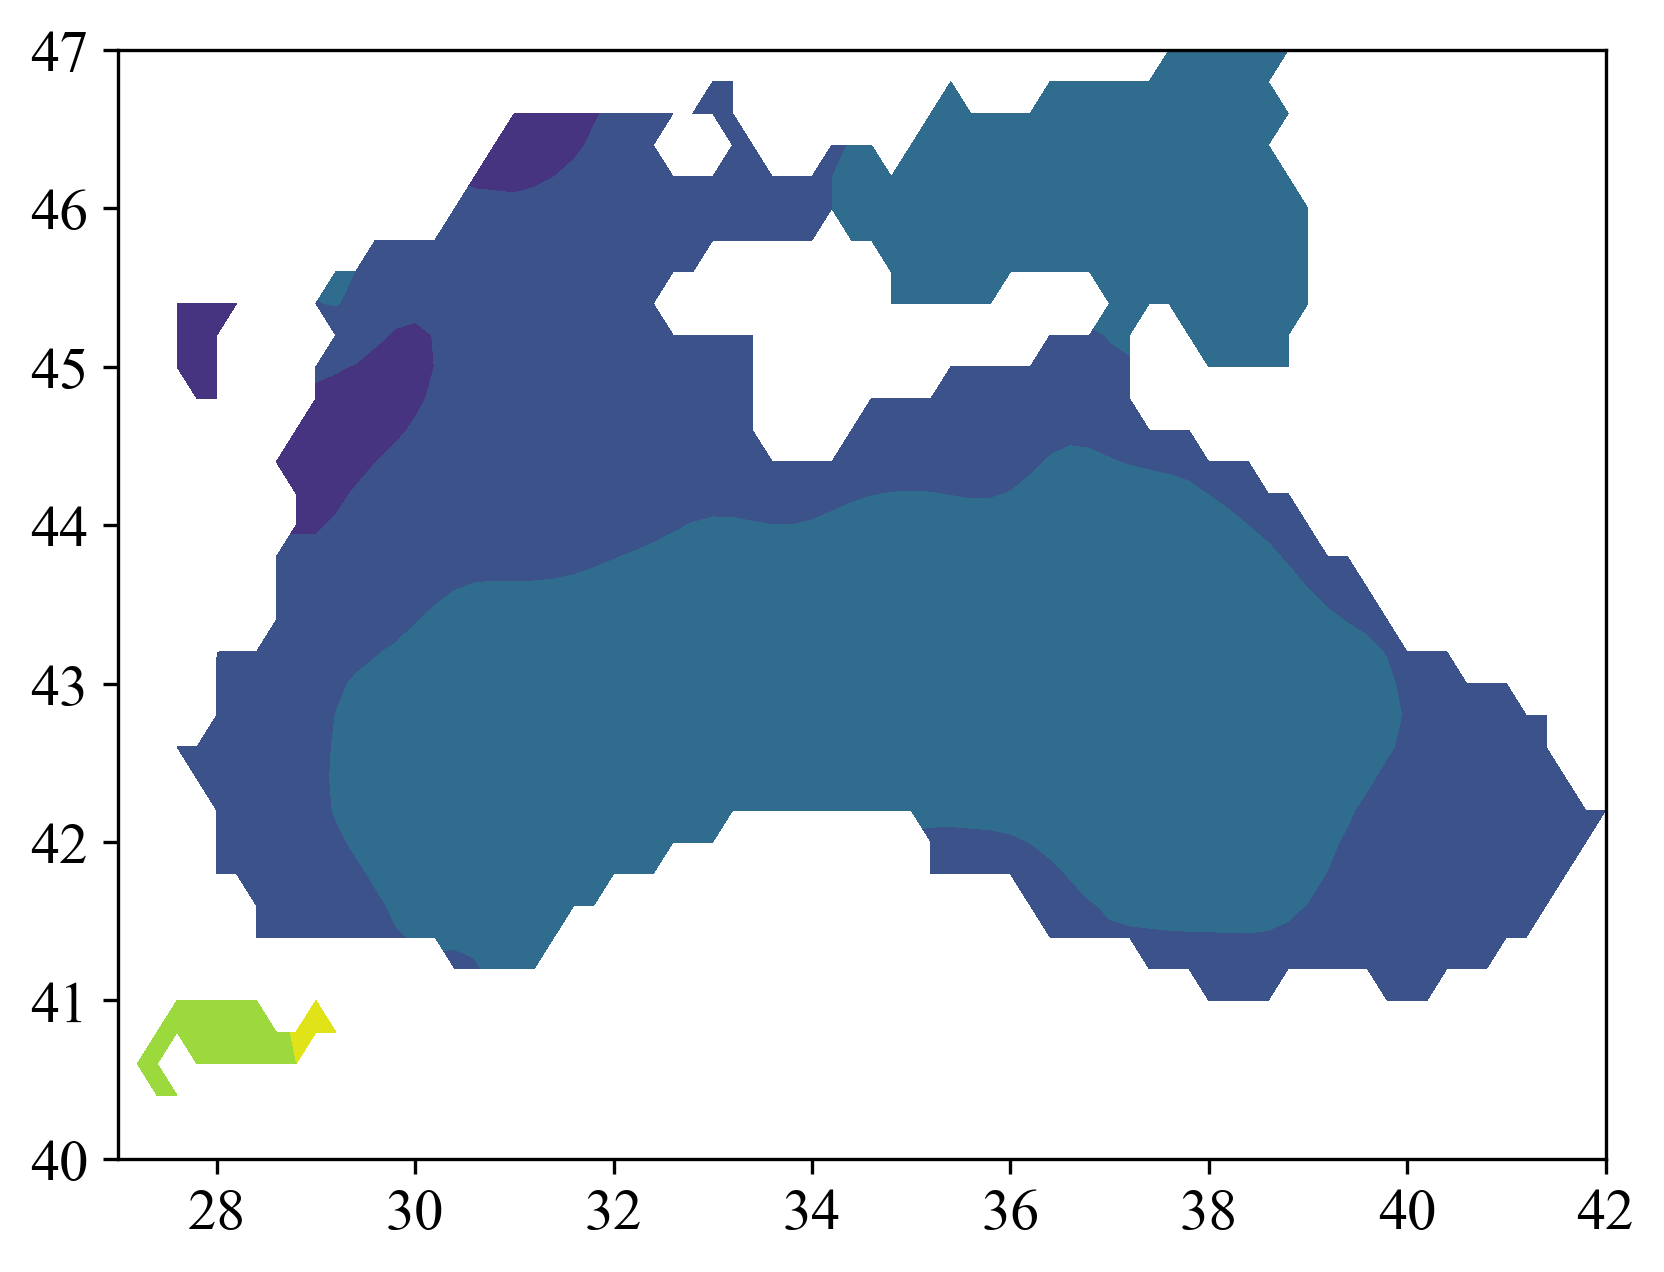

PyObject <matplotlib.contour.QuadContourSet object at 0x7f9b6f6347b8>

In [20]:
contourf(lon, lat, transpose(salinityplot), levels=collect(15:1:25))


# A typical mistake!
Did we close the netCDF file we've opened?    
It seems that's not the case.

In [33]:
NetCDF.close(nc)

LoadError: [91mNetCDF error code -33:
	NetCDF: Not a valid ID[39m